In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import time
import wandb
import pytorch_lightning as pl
import sqlite3

import FunctionCollection as fc
import importlib
fc = importlib.reload(fc)
import os

In [10]:
path = r'/groups/hep/jonasv'

run_name = 'Muon_Angle_m21'

args = {'N_edge_feats': 6,
        'N_dom_feats': 10,
        'N_targets': 2,
        'N_outputs': 3,
        'N_metalayers': 1,
        'N_hcs': 64,
        'diagonal_cov': True,
        'wandb_activated': True,
        'type': 'Spherical_NLLH',
        'zenith': True,
        'id': wandb.util.generate_id()[:4],
        'eps': 1e-5,
        'lr': 1e-3,
        'batch_size': 1024,
        'output_offset': [3.14,1.57],
        'filename': 'rasmus_classification_muon_1500k.db', #dev_level2_mu_tau_e_muongun_classification_wnoise_unscaled.db #dev_lvl7_mu_nu_e_classification_v003_unscaled.db
        'features': 'pulse_width, lc, SRTInIcePulses, string, dom, charge_log10, time, dom_x, dom_y, dom_z',
        'targets': 'azimuth, zenith',
        'TrTV': (0.9,0.95,1.),#(0.025,0.995,1)
        'SRT_clean': False
       }

In [19]:
########### FOR UNSCALED DATA
# centers = pd.DataFrame({'charge_log10': [-0.033858],
#                         'dom_time': [10700.0],
#                         'dom_x': [0],
#                         'dom_y': [0],
#                         'dom_z': [0],
#                         'width': [4.5],
#                         'rqe': [1.175]})
# scalers = pd.DataFrame({'charge_log10': [0.274158],
#                         'dom_time': [2699.0],
#                         'dom_x': [300],
#                         'dom_y': [300],
#                         'dom_z': [300],
#                         'width': [3.5],
#                         'rqe': [0.175]})
########### FOR SCALED DATA
centers = pd.DataFrame({'charge_log10': [0],
                        'time': [0],
                        'dom_x': [0],
                        'dom_y': [0],
                        'dom_z': [0],
                        'lc': [0.5],
                        'SRTInIcePulses': [0.5],
                        'string': [40],
                        'dom': [30],
                        'pulse_width': [4.5]})
scalers = pd.DataFrame({'charge_log10': [1],
                        'time': [1],
                        'dom_x': [1],
                        'dom_y': [1],
                        'dom_z': [1],
                        'lc': [0.5],
                        'SRTInIcePulses': [0.5],
                        'string': [20],
                        'dom': [15],
                        'pulse_width': [3.5]})

centers = centers[args['features'].split(', ')].values
scalers = scalers[args['features'].split(', ')].values

def x_transform(df):
    df = (df - centers)/scalers
    return torch.tensor(df.values)

y_centers = pd.DataFrame({'energy_log10': [2.28962877],
                          'azimuth': [3.17179598],
                          'zenith': [0.99478726]})
y_scalers = pd.DataFrame({'energy_log10': [1.03477065],
                          'azimuth': [3.18754927],
                          'zenith': [1.11991644]})

y_centers = y_centers[args['targets'].split(', ')].values
y_scalers = y_scalers[args['targets'].split(', ')].values

def y_transform(df):
    df = df*y_scalers + y_centers
    return torch.tensor(df.values)

# def y_transform(df):
#     return torch.tensor(df.values)

# from typing import List
# @torch.jit.script
# def batch_transform(x,events: List[int]):
#     tmp_x = x.unsqueeze(1) - x
#     cart = tmp_x[:,:,-3:]
    
#     rho = torch.norm(cart, p=2, dim=-1).unsqueeze(2)
#     rho_mask = rho.squeeze() != 0
#     if rho_mask.sum() != 0:
#         cart[rho_mask] = cart[rho_mask] / rho[rho_mask]
#     tmp_x = torch.cat([cart,rho,tmp_x[:,:,:-3]],dim=2)
#     return torch.cat([tmp_x.mean(1),tmp_x.std(1),tmp_x.min(1)[0],tmp_x.max(1)[0],x],dim=1)

In [5]:
# filepath = r"/groups/hep/pcs557/databases/dev_lvl7_mu_nu_e_classification_v003/data"
# sets = pd.read_pickle(os.path.join(filepath[:-4],'meta/sets.pkl'))

filepath = r"/groups/hep/jonasv/databases"

# filepath = r"/groups/hep/pcs557/databases/dev_level2_mu_tau_e_muongun_classification_wnoise/data"

# event_nos = pd.read_pickle(r"/groups/hep/jonasv/databases/Muon_event_nos_dev_level2_mu_tau_e_muongun_classification_wnoise_unscaled.pkl").sample(10000000)

############################ CHECK ./jonasv/databases for Muon event_nos #######################
# with sqlite3.connect(os.path.join(filepath,args['filename'])) as con:
#     query = "SELECT event_no FROM truth WHERE pid IN (-13,13)"
#     event_nos = pd.read_sql(query,con)
#################################################################################################

In [20]:
dataset = fc.custom_db_dataset(filepath = filepath,
                               filename = args['filename'],
                               features = args['features'],
                               targets = args['targets'],
                               TrTV = args['TrTV'],
                              #  event_nos = event_nos.to_numpy().reshape(-1),#sets['train'].to_numpy().reshape(-1),
                               x_transform = x_transform,
                               y_transform = y_transform,
                            #    batch_transform = batch_transform,
                               shuffle = True,
                               SRT_clean = args['SRT_clean'],
                              #  reweighter = ze_reweighter
                               )

In [21]:
train_loader, test_loader, val_loader = dataset.return_dataloaders(batch_size=args['batch_size'], num_workers=8)

In [22]:
import Model_Loaders.Model_21 as M
M = importlib.reload(M)

Net = M.Load_model(args['type'],args)
model = Net()

# device = torch.device('cuda')

# model.to(device);

if features = x, Charge should be at x[:,-5], time at x[:,-4] and pos at x[:,-3:]
Remember all accuracies are positive and defined to go towards 0 in the optimal case.


In [23]:
trainer, wandb_logger = fc.return_trainer(path = path,
                                          run_name = run_name,
                                          args = args,
                                        #   ckpt = run_name + '_latest.ckpt',
                                          patience = 5
                                          )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [24]:
torch.cuda.current_device()

0

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type         | Params
-----------------------------------------------
0 | act           | SiLU         | 0     
1 | scatter_norm  | scatter_norm | 100   
2 | x_encoder     | MLP          | 832   
3 | CoC_encoder   | MLP          | 3.6 K 
4 | convs         | ModuleList   | 71.2 K
5 | scatter_norm2 | scatter_norm | 640   
6 | decoder       | MLP          | 87.0 K
-----------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.653     Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /groups/hep/jonasv/lr_find_temp_model.ckpt


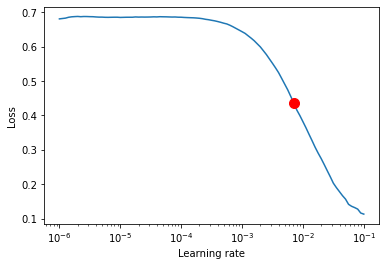

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
0.00707945784384138
if features = x, Charge should be at x[:,-5], time at x[:,-4] and pos at x[:,-3:]
Remember all accuracies are positive and defined to go towards 0 in the optimal case.


In [25]:
lr_finder = trainer.tuner.lr_find(model,train_loader,val_loader,min_lr=1e-6,max_lr=1e-1,num_training=100,mode='exponential',early_stop_threshold=4)

fig = lr_finder.plot(True,True)
print(lr_finder.suggestion())

args['lr'] = lr_finder.suggestion()
Net = M.Load_model(args['type'],args)
model = Net()
trainer, wandb_logger = fc.return_trainer(path = path,
                                          run_name = run_name,
                                          args = args,)

In [26]:
wandb.login(key='')

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /groups/hep/jonasv/.netrc


True

In [27]:
wandb_logger.experiment.config.update(args)
# wandb_logger.watch(model)
wandb_logger.experiment.log({f'lr finder, lr={lr_finder.suggestion()}': wandb.Image(fig)})

wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [28]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type         | Params
-----------------------------------------------
0 | act           | SiLU         | 0     
1 | scatter_norm  | scatter_norm | 100   
2 | x_encoder     | MLP          | 832   
3 | CoC_encoder   | MLP          | 3.6 K 
4 | convs         | ModuleList   | 71.2 K
5 | scatter_norm2 | scatter_norm | 640   
6 | decoder       | MLP          | 87.0 K
-----------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.653     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 1318: Val Acc reached 0.08185 (best 0.08185), saving model to "/lustre/hpc/hep/jonasv/checkpoints/Muon_Angle_m21_222t/Muon_Angle_m21-epoch=0-Val Acc=0.082.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 2637: Val Acc reached 0.06728 (best 0.06728), saving model to "/lustre/hpc/hep/jonasv/checkpoints/Muon_Angle_m21_222t/Muon_Angle_m21-epoch=1-Val Acc=0.067.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, step 3956: Val Acc was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 5275: Val Acc reached 0.06267 (best 0.06267), saving model to "/lustre/hpc/hep/jonasv/checkpoints/Muon_Angle_m21_222t/Muon_Angle_m21-epoch=3-Val Acc=0.063.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 6594: Val Acc reached 0.04829 (best 0.04829), saving model to "/lustre/hpc/hep/jonasv/checkpoints/Muon_Angle_m21_222t/Muon_Angle_m21-epoch=4-Val Acc=0.048.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 7913: Val Acc reached 0.04581 (best 0.04581), saving model to "/lustre/hpc/hep/jonasv/checkpoints/Muon_Angle_m21_222t/Muon_Angle_m21-epoch=5-Val Acc=0.046.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 9232: Val Acc reached 0.04161 (best 0.04161), saving model to "/lustre/hpc/hep/jonasv/checkpoints/Muon_Angle_m21_222t/Muon_Angle_m21-epoch=6-Val Acc=0.042.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 10551: Val Acc reached 0.03871 (best 0.03871), saving model to "/lustre/hpc/hep/jonasv/checkpoints/Muon_Angle_m21_222t/Muon_Angle_m21-epoch=7-Val Acc=0.039.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 11870: Val Acc reached 0.03766 (best 0.03766), saving model to "/lustre/hpc/hep/jonasv/checkpoints/Muon_Angle_m21_222t/Muon_Angle_m21-epoch=8-Val Acc=0.038.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 13189: Val Acc reached 0.03743 (best 0.03743), saving model to "/lustre/hpc/hep/jonasv/checkpoints/Muon_Angle_m21_222t/Muon_Angle_m21-epoch=9-Val Acc=0.037.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 14508: Val Acc reached 0.03622 (best 0.03622), saving model to "/lustre/hpc/hep/jonasv/checkpoints/Muon_Angle_m21_222t/Muon_Angle_m21-epoch=10-Val Acc=0.036.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 15827: Val Acc reached 0.03530 (best 0.03530), saving model to "/lustre/hpc/hep/jonasv/checkpoints/Muon_Angle_m21_222t/Muon_Angle_m21-epoch=11-Val Acc=0.035.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, step 17146: Val Acc was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 18465: Val Acc reached 0.03419 (best 0.03419), saving model to "/lustre/hpc/hep/jonasv/checkpoints/Muon_Angle_m21_222t/Muon_Angle_m21-epoch=13-Val Acc=0.034.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, step 19784: Val Acc was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 21103: Val Acc reached 0.03381 (best 0.03381), saving model to "/lustre/hpc/hep/jonasv/checkpoints/Muon_Angle_m21_222t/Muon_Angle_m21-epoch=15-Val Acc=0.034.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, step 22422: Val Acc was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 23741: Val Acc reached 0.03235 (best 0.03235), saving model to "/lustre/hpc/hep/jonasv/checkpoints/Muon_Angle_m21_222t/Muon_Angle_m21-epoch=17-Val Acc=0.032.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, step 25060: Val Acc was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 26379: Val Acc reached 0.03205 (best 0.03205), saving model to "/lustre/hpc/hep/jonasv/checkpoints/Muon_Angle_m21_222t/Muon_Angle_m21-epoch=19-Val Acc=0.032.ckpt" as top 1
/groups/hep/jonasv/anaconda3/envs/newenv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Epoch 20, step 26424: Val Acc was not in top 1


1

In [29]:
trainer.save_checkpoint(path + '/checkpoints/' + run_name + '_' + args['id'] + '/' + run_name + '_latest.ckpt')
print("potentially remember wandb.finish()")

potentially remember wandb.finish()


In [30]:
wandb.finish()

In [36]:
test_loader = dataset.return_dataloader(dataset.test(),args['batch_size'])

In [34]:
device = torch.device(torch.cuda.current_device())

model = Net.load_from_checkpoint(path + '/checkpoints/' + run_name + '_' + args['id'] + '/' + run_name + '_latest.ckpt')
# model = Net.load_from_checkpoint(path + '/checkpoints/' + run_name + '_' + args['id'] + '/OscNext_Angle_m21-epoch=7-Val Acc=0.348.ckpt')
model.to(device);

In [37]:
pred, truth = fc.return_reco_truth(model,test_loader)

Batch:  99%|█████████▊| 73/74 [00:20<00:00,  3.82it/s]

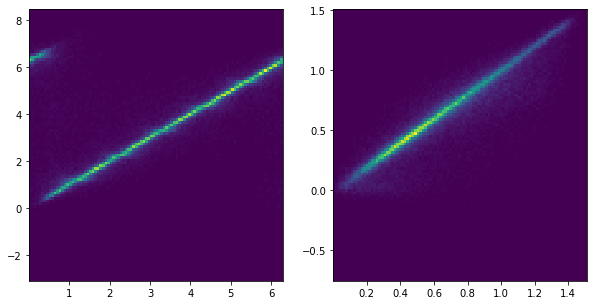

In [38]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2)

ax[0].hist2d(truth[:,0],pred[:,0]+3.14,bins=100)#,range=((-1,7.5),(-10,10)))
ax[1].hist2d(truth[:,1],pred[:,1]+1.57,bins=100);#,range=((-1,7.5),(-10,10)));

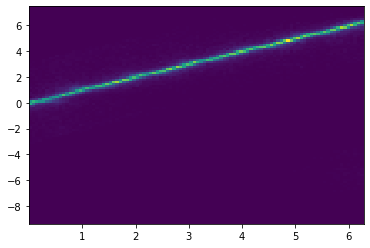

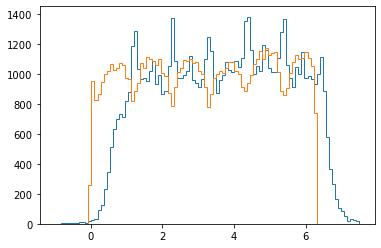

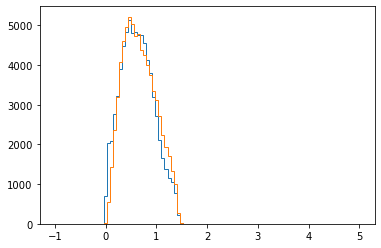

In [41]:
tmp = pred[:,0].copy() + 3.14
tmp[np.abs(tmp - truth[:,0]) > np.pi] -= 2*np.pi
fig, ax = plt.subplots()
ax.hist2d(truth[:,0],tmp,bins=100)#,range=((-1,7),(-1,7)));
np.quantile(abs(tmp - truth[:,0])*180/np.pi,(0,0.68))

fig, ax = plt.subplots()
ax.hist(pred[:,0]+3.14,bins=100,range=(-1,7.5),histtype='step');
ax.hist(truth[:,0],bins=100,range=(-1,7.5),histtype='step');

fig, ax = plt.subplots()
ax.hist(abs(pred[:,1]+1.57),bins=100,range=(-1,2*2.5),histtype='step');
ax.hist(truth[:,1],bins=100,range=(-1,2*2.5),histtype='step');

# fig = plt.figure(figsize=(7,7))
# ax = fig.add_axes([0.1, 0.1, 0.8, 0.8],polar=True)
# ax.hist(truth[:,0],bins=100);
# ax.hist(pred[:,0]+3.14,bins=100,alpha=0.5);
# # help(ax)

# fig = plt.figure(figsize=(7,7))
# ax = fig.add_axes([0.1, 0.1, 0.8, 0.8],polar=True)
# ax.hist(truth[:,1],bins=100);
# ax.hist(abs(pred[:,1]+1.57),bins=100,alpha=0.5);

In [42]:
def Omega(azp,zep,azt,zet):
    s1 = np.sin( zet + azt - azp )
    s2 = np.sin( zet - azt + azp )
    c1 = np.cos( zet - zep )
    c2 = np.cos( zet + zep )
    return np.arccos(0.5*np.abs(np.sin(zep))*( s1 + s2 ) + 0.5*(c1 + c2))*180/np.pi
O = Omega(pred[:,0] +3.14, pred[:,1] + 1.57, truth[:,0], truth[:,1])

array([0.00895517, 4.7742259 , 8.62118191])

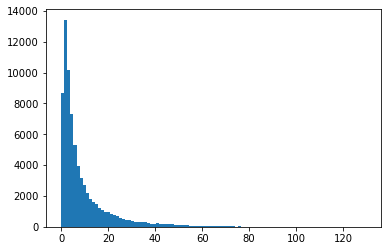

In [45]:
fig, ax = plt.subplots()
ax.hist(O,bins=100);
np.quantile(O,(0,0.5,0.68))

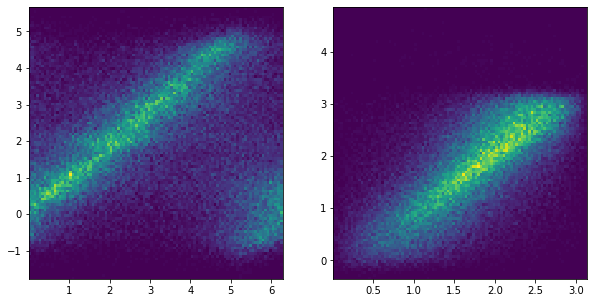

In [25]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2)

ax[0].hist2d(truth[:,0],pred[:,0]+3.14,bins=100)
ax[1].hist2d(truth[:,1],pred[:,1],bins=100);

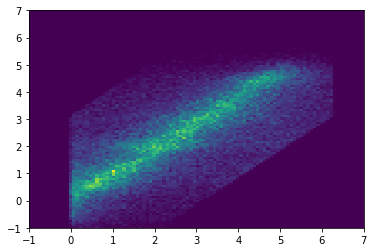

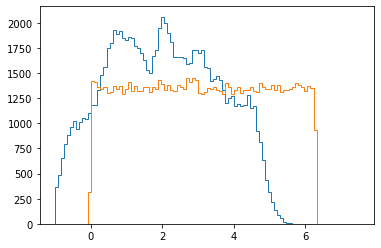

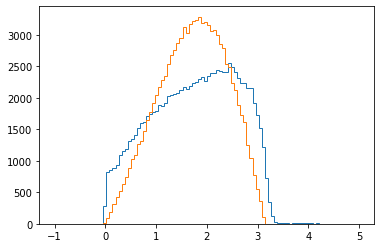

In [46]:
tmp = pred[:,0].copy() + 3.14
tmp[np.abs(tmp - truth[:,0]) > np.pi] -= 2*np.pi
fig, ax = plt.subplots()
ax.hist2d(truth[:,0],tmp,bins=100,range=((-1,7),(-1,7)));
np.quantile(abs(tmp - truth[:,0])*180/np.pi,(0,0.68))

fig, ax = plt.subplots()
ax.hist(pred[:,0]+3.14,bins=100,range=(-1,7.5),histtype='step');
ax.hist(truth[:,0],bins=100,range=(-1,7.5),histtype='step');

fig, ax = plt.subplots()
ax.hist(abs(pred[:,1]),bins=100,range=(-1,2*2.5),histtype='step');
ax.hist(truth[:,1],bins=100,range=(-1,2*2.5),histtype='step');

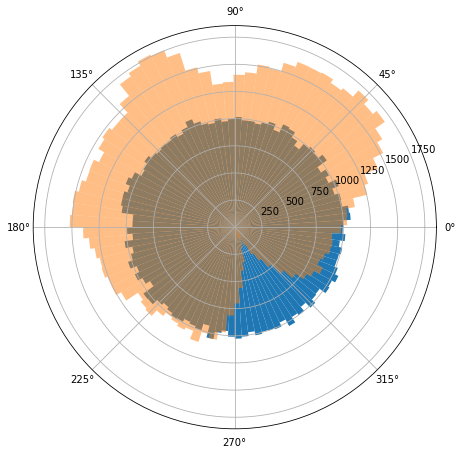

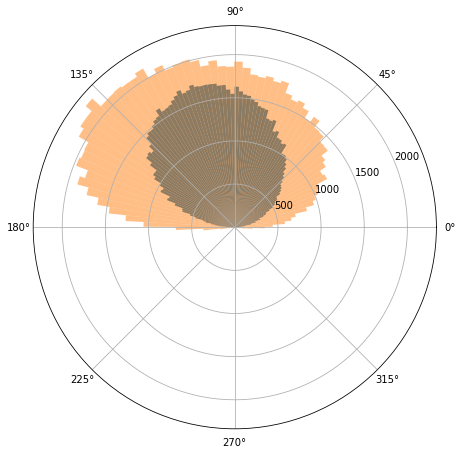

In [49]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8],polar=True)
ax.hist(truth[:,0],bins=100);
ax.hist(pred[:,0]+3.14,bins=100,alpha=0.5);
# help(ax)

fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8],polar=True)
ax.hist(truth[:,1],bins=100);
ax.hist(pred[:,1],bins=100,alpha=0.5);

In [24]:
output, cov = model.output_post_processor(torch.tensor(pred))
y = model.y_post_processor(torch.tensor(truth))

# model.cal_acc(torch.tensor(pred[:,:2] + args['output_offset']),torch.tensor(truth))
model.crit(output,cov,y,None), model.cal_acc(output,y)

(tensor(-0.1176, dtype=torch.float64), 0.42082032561302185)

In [32]:
wandb.finish()